# Predicting scientific success with a Long-Short Term Memory Network (LSTM)

### Eleftherios P. Loukas - 2029
### Panagiotis Nikitakis - 1717

--------------------------------
The development of this code was done in Google Colaboratory instead of a standard local Jupyter notebook.

With this way, we could collaborate and edit the code with versioning control without having to worry about the setup of libraries and dependencies locally.

**Also, we accelerated the training process heavily by using a GPU for the computing processes, without any cost, unlike AWS or Azure. **

----------------------------------------------
Our VM's hardware specs:

***GPU: 1x Tesla K80, having 2496 CUDA cores, 12GB GDDR5 VRAM***

*CPU: 1x single core hyper threaded Xeon Processors @2.3Ghz i.e (1 core, 2 threads)*

# Import Libraries

Pandas: *data-analysis tools and handling of the dataset*

sci-kit learn: *efficient machine learning tools *

keras:* deep learning library for Python (we used the TensorFlow backend)*

NumPy: *numerical actions *

Matplotlib: *plotting* 


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import time, os

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv, concat, DataFrame

from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error, explained_variance_score, r2_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Masking, LSTM, Dropout, SimpleRNN, GRU, BatchNormalization, ConvLSTM2D
from keras import callbacks, optimizers

from random import choice

# Authorize Google's Drive I/O

Since we use Google Colaboratory, we uploaded our files to Google Drive so we can access them online at any time. 

In order to use them in a Colab Notebook (Jupyter Notebooks run in Google's Colaboratory), you need to have access to the files and then authorize the Google's Drive I/O.

In [25]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Change directory to where input files for the project are located

The input files have been gathered from the dataset 'Citation - V1' from [Aminer.org](https://aminer.org/citation)

Then, they were processed with a python script that put the papers' index id in each row and the papers' citations in each year, after the release of each paper, in each column.

Also, because there were many missing connections between papers, we had many zeros and ones. 
That's why we decided to delete some of these rows (i.e. those who had more than 3 zeros), so the distribution of the dataset was a normal one.

The python script is attached to our e-mail submission and you can find it there.

A visualization of the dataset transformation will continue later.

# Read the dataset with Pandas library

As you can see, we chose a dataset with 11 years, starting from year-0, ending to year-10.


In [26]:
input_files_pathname = "/content/gdrive/My Drive/Colab Notebooks/CE418 - NFC/project2/input files"

%cd $input_files_pathname

%ls

filename = "10years_3zeros.xlsx"
dataset = pd.read_excel(filename)

/content/gdrive/My Drive/Colab Notebooks/CE418 - NFC/project2/input files
10years_0zeros.xlsx  15years_6zeros.xlsx   9years_1zeros.xlsx
10years_1zeros.xlsx  15years_9zeros.xlsx   9years_2zeros.xlsx
10years_2zeros.xlsx  20years_12zeros.xlsx  create_training_set.py
10years_3zeros.xlsx  20years_8zeros.xlsx   how_to_run_script.png
10years_4zeros.xlsx  8years_3zeros.xlsx
10years_6zeros.xlsx  9years_0zeros.xlsx


In [27]:
 dataset.head()

,year_0,year_1,year_2,year_3,year_4,year_5,year_6,year_7,year_8,year_9,year_10
30370,0,1,0,1,2,3,4,1,0,1,1
74368,0,2,0,0,1,3,1,1,3,3,3
74440,3,0,7,12,10,11,5,3,10,3,1
74464,0,1,1,3,4,1,3,3,1,1,0
74545,0,2,1,1,7,6,1,13,4,7,1


Also, in order to have a good variance of our model, we chose to remove papers that had more than 3 years with 0 citations, since their distribution was major in the dataset (!) and resulted to having predictions always close to zero, which is not generalizing well enough.

# Define X, y
### We define as features (X) all the citation counts starting from a year 0 and ending to a year k-1
### Then, we define as target (y) a 2d vector with the following year k and the year k+4.

Since, for our problem, the input years will be the first 6 and we will consider as output the 7th and the 11th.

Eventually, we believe that the number of 6 years past are good for determining how a paper will proceed to the future.

In [0]:
X = dataset.iloc[:, 0:-5].values # Take the first 6 years as training

y = dataset.iloc[:, [-5, -1]].values # Take the 7th and 11th year as targets
#y = dataset.iloc[:, -5].values # Take the 7th and 11th year as targets

In [29]:
print(X.shape) # (629803, 6) # Second column is the number of features
print(y.shape) # (629803, 2) - Second column is the number of targets

(4156, 6)
(4156, 2)


# Getting ready for the training process
## Splitting into train, validation & test sets

We split the dataset into a training & validation set. The training set will be used in order to train/fit the model, with respect to the validation set. **We consider a validation set in order to perform early stopping, a well-known methodology that is used to prevent overfitting.**

Overfitting is when your model starts to 'learn' your data explicitly and is not generalized well enough. By providing the validation set, we will monitor the behavior of the training loss *with respect to the behavior of the validation loss* and stop when it's about to start overfitting.

Lastly, we will perform evaluation on a test set given by the instructor.
## Normalize the dataset 

Another thing that we do in these pre-processing steps, is normalizing the data range.
Normalizing maps our feature value ranges *(let's say [0, 147])* to another range *(let's say [-1, 1])*.
It is known (statistically-saying) that normalizing your dataset helps in neural networks in approximating.

## [Reshape the dataset](https://machinelearningmastery.com/reshape-input-data-long-short-term-memory-networks-keras/) 
Last but not least, most DL frameworks (such as Keras/TensorFlow/PyTorch) require a dataset to have a 3-dimensional shape when it's an input to an RNN/GRU/LSTM. 


In [0]:
#Split set to train and validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.10, random_state = 42)

# Robust Normalization
# Scaler-normalizer object for X_s
scaler = RobustScaler() # The RobustScaler method seemed to be the best normalizer when training
scaler.fit(X)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

# Scaler-normalizer object for y_s
scaler_for_y = RobustScaler()
scaler_for_y.fit(y)

y_train = scaler_for_y.transform(y_train)
y_val = scaler_for_y.transform(y_val)

# Reshaping 
# Change the number of features (input for the LSTM units) for the LSTM
number_of_features = X.shape[1]
number_of_timesteps = 1

X_train = X_train.reshape(X_train.shape[0], number_of_timesteps, X_train.shape[1])
X_val = X_val.reshape(X_val.shape[0], number_of_timesteps, X_val.shape[1])
# The shape now is 3d
# (#samples, #timesteps, #features/columns)

number_of_predictions = 2

## Design the Neural Network Model, fit it and show training/validation loss
# DO NOT RUN THESE BLOCKS WHEN EVALUATING

### Architecture
Using the Keras Sequential model, we define:

*   LSTM layer with 32 units, describing the input shape since it's the 1st layer of the model
*   Dense layer with 2 outputs, since we want 2 predictions

We picked LSTM since it's one of the state-of-the-art RNN variations.

It uses some gates (input, forget, update & output gates) that learn to alter the signal memory in a way that can handle both short memories (like the 6 first years in our problem) but also problems with long memories.

### Optimization

*   [Adam Optimizer by Kingma & Ba, ICLP, San Diego, 2015](https://arxiv.org/abs/1412.6980)

Adam has been one famous, new (released on 2014!), optimizer used in the literature and it proved really good results to us when training, in our specific problem. We used a batch_size of 1 since it had better results than the mini-batches of 32 or so.

### Cost Function
As our problem is a regression problem, we used the simple **mean absolute error** as our cost/loss function when evaluating the validation set.

### Avoiding overfitting
As explained earlier, we monitored the loss on a validation set in order to early-stop our model training and avoid overfitting.

Also, we incorporated dropout into some of our layers with an arbitrary probability.

*   [Dropout: A Simple Way to Prevent Neural Networks from
Overfitting, The Journal of Machine Learning ](http://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf?utm_content=buffer79b43&utm_medium=social&utm_source=twitter.com&utm_campaign=buffer)

### Regularization in weights & biases

We used the Xavier uniform initialization for most weights and biases since this will help our model find a local minimum faster and not to oscillate in saddle points.

 






Train on 3740 samples, validate on 416 samples
Epoch 1/100
3740/3740 [==============================] - 36s 10ms/step - loss: 0.6278 - val_loss: 0.6143
Epoch 2/100
3740/3740 [==============================] - 33s 9ms/step - loss: 0.6164 - val_loss: 0.6041
Epoch 3/100
3740/3740 [==============================] - 31s 8ms/step - loss: 0.6130 - val_loss: 0.6027
Epoch 4/100
3740/3740 [==============================] - 29s 8ms/step - loss: 0.6118 - val_loss: 0.6013
Epoch 5/100
3740/3740 [==============================] - 28s 7ms/step - loss: 0.6081 - val_loss: 0.6031
Epoch 6/100
3740/3740 [==============================] - 28s 8ms/step - loss: 0.6137 - val_loss: 0.6025
Epoch 00006: early stopping

Training time took '185.3975' seconds using GPU hardware acceleration, using a batch size of 1 




 EVALUATING --- EVALUATING --- EVALUATING  ---
416/416 [==============================] - 1s 2ms/step
Testing time took '0.8611' seconds using GPU hardware acceleration, using a batch size of 1 
Disc

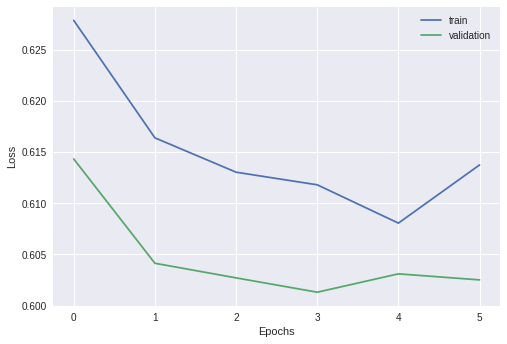

In [0]:
# Design the Neural Network Architecture
model = Sequential()

#model.add(LSTM(64, input_shape=(None, X_train.shape[2]), activation='tanh', dropout = 0.6))
model.add(LSTM(32, input_shape=(None, number_of_features), activation='tanh', dropout=0.2, bias_initializer= 'glorot_uniform'))

model.add(Dense(number_of_predictions)) 

# Cost Function & Optimization
# Mean Square Error as the Cost/Loss function
# Adam as the Optimizer/Backpropagation Algorithm
optimizer = optimizers.Adam(lr=0.001 , beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='mae', optimizer=optimizer) 

# Early Stopping
# This way, the model will avoid overfitting
early_stopping = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0, patience=2, verbose=1, mode='auto')

# Fit network, train it on a sample of the dataset and validate
start = time.time()

history = model.fit(X_train, y_train, epochs = 100, batch_size = 1, validation_data = [X_val, y_val], verbose=1, shuffle=True, callbacks = [early_stopping])

end = time.time()
print("\nTraining time took '{}' seconds using GPU hardware acceleration, using a batch size of 1 \n\n".format(np.round(end - start, 4)))

# Evaluate network, test it on a sample of the dataset
print("\n\n EVALUATING --- EVALUATING --- EVALUATING  ---")
start = time.time()
score = model.evaluate(X_val, y_val, batch_size=1)
end = time.time()
print("Testing time took '{}' seconds using GPU hardware acceleration, using a batch size of 1 ".format(np.round(end - start, 4)))
print("Disclaimer: The testing set is actually a validation set. The real test set will be given by the instructor.")

print("\nMAE on the validation dataset is " + str(score))
print(model.metrics_names)

# Plot training loss and validation loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


## The final values of the weights and the biases

In [0]:
for layer in model.layers:
  print(layer)
  print("Weights :")
  print(layer.get_weights()[0])
  print("----####---####------####---####------####---####------####---####------####---####------####---####--")      
  print("Biases:")
  print(layer.get_weights()[1])
  print("----####---####------####---####------####---####------####---####------####---####------####---####--")    


Weights :
[[-1.38232365e-01 -3.31130326e-01 -3.62527780e-02 -1.77320078e-01
   1.27907600e-02  6.00067005e-02 -4.49757054e-02  3.09125520e-02
  -1.83877200e-01  2.07939714e-01 -3.39627117e-01 -3.44975037e-03
   9.12871435e-02  2.35713311e-02  4.41890769e-02 -1.23700283e-01
  -1.49589717e-01 -6.41009659e-02  4.44841757e-02  1.26717538e-01
   4.52421941e-02  6.45133331e-02 -1.05174944e-01 -1.08511090e-01
  -5.15752882e-02 -1.03001714e-01 -8.71906504e-02 -2.85449088e-01
   3.23340595e-02  2.84455478e-01  1.88266411e-02 -2.30123088e-01
  -1.15123987e-02  2.61731446e-03  9.11552161e-02 -8.79043117e-02
   1.52605101e-01 -1.25344664e-01  1.06085435e-01  1.71430603e-01
   2.36435235e-03  4.91200835e-02 -5.61409891e-02 -9.91802514e-02
   1.68122947e-02 -1.14367239e-01 -7.88214803e-03  1.99355111e-01
   1.72620073e-01 -1.00033730e-02  1.91679314e-01 -1.31226450e-01
  -1.98983654e-01 -6.01175278e-02  1.40054032e-01  1.09672740e-01
  -2.08130836e-01  3.79014015e-02  1.36086047e-02  1.03957847e-01


#### Display non-normalized MAE and MSE

In [0]:
y_hat = model.predict(X_val)

y_hat_rescaled = scaler_for_y.inverse_transform(y_hat)
y_val_rescaled = scaler_for_y.inverse_transform(y_val)

print("---METRICS------METRICS------METRICS---")
print(mean_absolute_error(y_val_rescaled, y_hat_rescaled)) # MAE
print(mean_squared_error(y_val_rescaled, y_hat_rescaled)) # MSE

---METRICS------METRICS------METRICS---
1.8075261497870088
11.254490946375494


## Summary of the model

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                4992      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
Total params: 5,058
Trainable params: 5,058
Non-trainable params: 0
_________________________________________________________________


# Save the trained model


In [0]:
input_files_pathname = "/content/gdrive/My Drive/Colab Notebooks/CE418 - NFC/project2/"

%cd $input_files_pathname

model.save('lstm.h5')  # creates a HDF5 file 'lstm.h5'


/content/gdrive/My Drive/Colab Notebooks/CE418 - NFC/project2


# The code below is for testing purposes only.
![alt text](https://www.annuitas.com/wp-content/uploads/2014/09/testing.jpg)




# Load the trained/saved model
Apparently, you have to upload your txt files to the drive.

In [31]:
input_files_pathname = "/content/gdrive/My Drive/Colab Notebooks/CE418 - NFC/project2/"

%cd $input_files_pathname

model = load_model('lstm.h5')

/content/gdrive/My Drive/Colab Notebooks/CE418 - NFC/project2


## Methods for reading the test set

### Change directory to the test path

In [32]:
# Change to the folder of the test set timeseries
test_set_pathname = "/content/gdrive/My Drive/Colab Notebooks/CE418 - NFC/project2/test_set_timeseries"
%cd $test_set_pathname
%ls



/content/gdrive/My Drive/Colab Notebooks/CE418 - NFC/project2/test_set_timeseries
timeseries01.txt  timeseries04.txt  timeseries07.txt  timeseries10.txt
timeseries02.txt  timeseries05.txt  timeseries08.txt
timeseries03.txt  timeseries06.txt  timeseries09.txt


### Read timeseries

In [0]:
def read_timeseries():
  
  # Initialization
  directory = "." 
  timeseries = []
  dictionary = {}

  for filename in os.listdir(directory):
      if filename.startswith("timeseries") and filename.endswith(".txt"): 

          # text_file = open(directory+"\\"+filename, "r") # Uncomment this if you use an absolute path
          text_file = open(filename, "r") # Uncomment this if you use this directory
          line = text_file.read().split(',')
          text_file.close()
          for idx, val in enumerate(line):
              line[idx] = int(val)

          #which file is that?
          index = filename.find(".txt")
          key = filename[index-2:index]
          dictionary[int(key)] = line

          continue
      else:
          continue 

  for i in range(0, 10):
      try:
          timeseries.append(dictionary[i+1])
      except:
          print("Error from the input files")


  print(timeseries)
  return timeseries


### Clip and pad timeseries

In [0]:
# Call clip_and_pad(timeseries, 5, 0, "last")
# 1st arg: timeseries object as 2d ARRAY
# 2nd arg: input length; 3rd arg: Insert 0s or 1s when padding;
# 4th arg: Delete "first" or "last" digits when clipping
def clip_and_pad(timeseries, input_length, flag_insert_zeros_or_ones, flag_delete_first_or_last_digits):

  # Change parameters
  #input_length = 5 
  #flag_insert_zeros_or_ones = 0; #0 or 1
  #flag_delete_first_or_last_digits = "last" #"first" or "last"

  for index, row in enumerate(timeseries):
      # For debugging purposes only
      #print(row)
      #print("LENGTH:", len(row))
      while len(row) < input_length:
          if flag_insert_zeros_or_ones == 0:
              timeseries[index].insert(0, 0)
          else:
              timeseries[index].insert(0, 1)
      if len(row) > input_length:
          if flag_delete_first_or_last_digits == "first":
              del timeseries[index][ : (len(row) - input_length)]
          else:
              del timeseries[index][-(len(row) - input_length) : ]

      # For debugging purposes only
      #print(row)
      #print("----")

  # For debugging purposes only
  #for index, row in enumerate(timeseries):
  #    print("Length: ", len(row))

  #print(timeseries)
  return timeseries

#print(clip_and_pad(timeseries, 5 , 0, "last")) 

### Load, process the test dataset and evaluate on it

Just like before, we normalize the features by using the robust scaler method.

In [35]:
# Targets

# Scaler-normalizer object for X_s
scaler = RobustScaler() 
scaler.fit(X)

# Scaler-normalizer object for y_s
scaler_for_y = RobustScaler()
scaler_for_y.fit(y)

timeseries = read_timeseries()

timeseries = clip_and_pad(timeseries, number_of_features, 0, "first")

timeseries = scaler.transform(timeseries) # Normalize X's

timeseries = timeseries.reshape(timeseries.shape[0], number_of_timesteps, timeseries.shape[1])

predictions = model.predict(timeseries)

predictions = scaler_for_y.inverse_transform(predictions) # Inverse transform Y's

print(predictions)


[[2, 6, 3, 4, 10, 11, 4, 4, 8, 3, 3], [1, 4, 3, 3, 6, 12, 32, 18, 46, 69, 93, 105, 133, 144, 167, 194, 153, 140, 129], [3, 1, 14, 19, 9, 20, 32, 52, 34, 55, 57, 63, 59, 49, 57, 67, 66, 71, 68, 66], [5, 6, 15, 6, 19, 8, 9, 13, 11, 12, 17, 7, 5, 7, 7, 4, 4], [7, 5, 4, 6, 5, 6, 1, 2], [2, 9, 9, 11, 7, 8, 8], [5, 5, 3, 9, 4, 7, 3, 6, 4, 4, 2, 6, 2], [1, 31, 42, 62, 56, 69, 60], [1, 6, 8, 10, 13, 13, 17, 17, 23, 21, 19, 17, 15], [2, 3, 2, 13, 11, 12, 22, 16, 23, 26, 22, 29, 56, 84, 66, 99, 126, 114, 158, 186, 230, 245, 204, 195, 222, 282, 227, 229, 274, 241, 237, 206, 209]]
[[ 2.7027173  1.5342493]
 [11.893689   5.532598 ]
 [11.920185   5.5500383]
 [ 3.115903   1.4925348]
 [ 2.139292   1.0261474]
 [ 5.8639784  2.815991 ]
 [ 2.4654846  1.1891589]
 [14.142859   7.1024575]
 [ 9.723364   4.3703256]
 [11.893689   5.532598 ]]
